<a href="https://colab.research.google.com/github/prashun07/Detecting-and-Localizing-pneumonia-/blob/master/VGG16Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Detecting pneumonia using pretrained **vgg16** **model**

#**Import** **Utilities**

In [1]:
#These are some basic Utilites we will need.
import os #To handle dataset
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torchvision.datasets import ImageFolder #to load data from folder
from torch.utils.data import DataLoader 
import torchvision.transforms as tt #to tansform image into tensors
from torch.utils.data import random_split #for spliting dataset into train and validation set
from torchvision.utils import make_grid 

#to draw images in notebook
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [4]:
dataset_url='https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia'
od.download(dataset_url)

  0%|          | 8.00M/2.29G [00:00<00:29, 83.0MB/s]

100%|██████████| 2.29G/2.29G [00:32<00:00, 76.4MB/s]


In [5]:
data_dir='/content/chest-xray-pneumonia/chest_xray/train'

In [6]:
os.listdir(data_dir)

['PNEUMONIA', 'NORMAL']

In [7]:
dataset=ImageFolder(data_dir)

In [8]:
dataset.classes

['NORMAL', 'PNEUMONIA']

In [9]:
len(dataset)

5216

#Explore Data

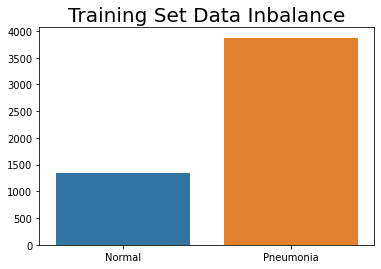

In [10]:
# number of images for each class

train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

#Load data and Convert into tensor

In [11]:
dataset = ImageFolder(data_dir,
                      transform=tt.Compose([tt.Resize((224,224)),
                                            #tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.ToTensor()
                                           ]))

In [12]:
dataset[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]), 0)

torch.Size([3, 224, 224])
torch.Size([224, 224, 3])
0


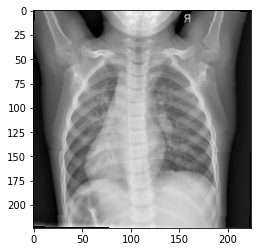

In [13]:
img,label=dataset[0]
print(img.shape)
print(img.permute(1,2,0).shape)
plt.imshow(img.permute(1,2,0))
print(label)

In [14]:
#split dataset in train and validation dataset
val_size=1500
train_size=len(dataset)-val_size
train_data,val_data=random_split(dataset,[train_size,val_size])
len(train_data),len(val_data)

(3716, 1500)

In [15]:
batch_size=128
train_dl=DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=4,pin_memory=True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

#Model
VGG model:

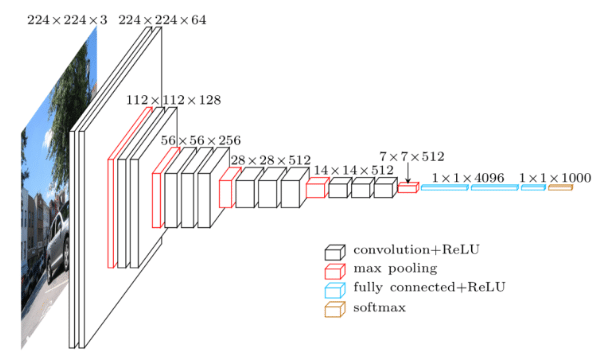

In [16]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [17]:
from torchvision import models
class VGG(ImageClassificationBase):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG16 network
        self.vgg16=models.vgg16(pretrained=True)
        
    def forward(self, x):
        x = self.vgg16(x)
        return x


In [18]:
model=VGG()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


#Training Utilities

In [19]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Gpu functions

In [20]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [21]:

device = get_default_device()
device

device(type='cuda')

In [22]:

#Load data into GPU
train_dl = DeviceDataLoader(train_dl, device)
val_dl=DeviceDataLoader(val_dl, device)

In [23]:
to_device(model, device);

In [24]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.0, 'val_loss': 8.453836441040039}]

#Training Model

In [25]:
epochs = 10
max_lr = 0.001
grad_clip = 0.1
weight_decay = 1e-4
opt_func = torch.optim.Adam

In [27]:
%%time
history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, 
                         grad_clip=grad_clip, 
                         weight_decay=weight_decay, 
                         opt_func=opt_func)


Epoch [0], train_loss: 0.9722, val_loss: 0.2179, val_acc: 0.9067



Epoch [1], train_loss: 0.1668, val_loss: 2.1499, val_acc: 0.7551



Epoch [2], train_loss: 1.1788, val_loss: 0.7374, val_acc: 0.7551



Epoch [3], train_loss: 0.6777, val_loss: 1.6936, val_acc: 0.2449



Epoch [4], train_loss: 0.6228, val_loss: 0.4913, val_acc: 0.8428



Epoch [5], train_loss: 0.4290, val_loss: 0.9549, val_acc: 0.7780



Epoch [6], train_loss: 0.2612, val_loss: 0.2090, val_acc: 0.9044



Epoch [7], train_loss: 0.1881, val_loss: 0.1553, val_acc: 0.9394



Epoch [8], train_loss: 0.1359, val_loss: 0.1457, val_acc: 0.9417



Epoch [9], train_loss: 0.1466, val_loss: 0.1406, val_acc: 0.9408
CPU times: user 2min 20s, sys: 2min 32s, total: 4min 52s
Wall time: 15min 27s


In [29]:
#function to plot accuracy
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

#function to plot losses
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

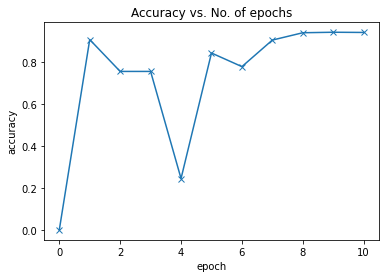

In [30]:
plot_accuracies(history)

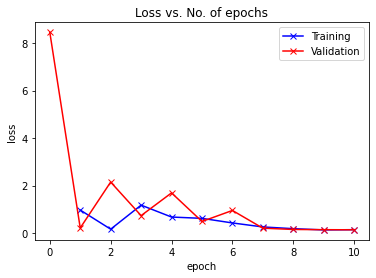

In [31]:
plot_losses(history)

#Testing Model

In [32]:
test_dir='/content/chest-xray-pneumonia/chest_xray/test'
testset = ImageFolder(test_dir,
                      transform=tt.Compose([tt.Resize((224,224)),
                                            #tt.CenterCrop(224),
                                            tt.RandomHorizontalFlip(),
                                            tt.RandomRotation(10),
                                            tt.RandomGrayscale(),
                                            tt.ToTensor()
                                           ]))

In [33]:
# Evaluate test set
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.7912946343421936, 'val_loss': 0.8396185636520386}

We got an accuracy of approx 79% on test dataset

Model: Vgg16

Image size:224x224

Batch_size=128

Epochs:10

Training accuracy:94.17%(approx)

Test accuracy:79.12%(approx)